In [644]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import json
import numpy as np
import os
legislators_historic = pd.read_csv('./data/legislators-historic.csv')
legislators_current = pd.read_csv('./data/legislators-current.csv')

In [645]:
filtered_legislators_current= legislators_current[legislators_current.party.isnull()== False]
filtered_legislators_historic = legislators_historic[legislators_historic.party.isnull()==False]

In [646]:
filtered_legislators_current.party.unique()

array(['Democrat', 'Republican', 'Independent'], dtype=object)

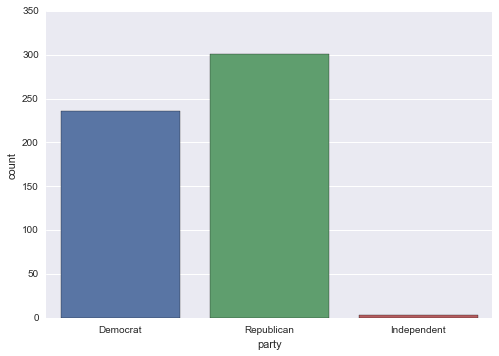

In [647]:
# this returns 236 - google says its 234 (independents maybe add on?)
filtered_legislators_current[filtered_legislators_current.party == "Democrat"].count()
sns.set(style="darkgrid")
curr_parties = sns.countplot(x="party", data=filtered_legislators_current)

In [648]:
content_list = []
years = []
yearVotes = {}
congress_no = "data/108/"
# Documentation on the votes https://github.com/unitedstates/congress/wiki/votes
congress_votes = congress_no + "votes/"

for content in os.listdir(congress_no):
    if content != '.DS_Store':
        content_list.append(content)
        
for year in os.listdir(congress_votes):
    years.append(year)    
    house_count = 0
    senate_count = 0
    for chamber in os.listdir(congress_votes + year):
        if chamber[0] == "h":
            house_count +=1
        if chamber[0] == "s":
            senate_count += 1
    yearVotes[year] = {'senate_count':senate_count, 'house_count':house_count}


yearVotes

{'2003': {'house_count': 677, 'senate_count': 459},
 '2004': {'house_count': 544, 'senate_count': 216}}

In [660]:
# Look what categories exist in general
current_year = "2003"
categories = []
senate_path = congress_votes+current_year+"/s"
house_path = congress_votes+current_year+"/h" 

for i in range(1,senate_count):
    data = senate_path+str(i)+"/data.json"
    json_file = open(data, 'r')
    x = json.loads(json_file.read())
    categories.append(str(x['category']))
    
set(categories)

{'amendment', 'cloture', 'nomination', 'passage', 'procedural', 'treaty'}

In [661]:
# "Foreign" related bills and amendments in the House
res_docs = []
wordSearch = "Foreign"
for i in range(1, house_count+1):
    path = house_path + str(i) + '/data.json'
    f = open(path, 'r')
    x = json.loads(f.read())
    if wordSearch in x["question"]:
        res_docs.append(i)
        
res_docs

[314, 369, 424, 429, 539]

In [676]:
# Parse Vote Document
# https://www.govtrack.us/data/congress/108/votes/2003/h424/data.json

def arrange_dict(res_docs):
    vote_types = ["Nay", "Not Voting", "Present", "Yea"]

    res_dict = {}
    res_dict['bill_title'] = []
    res_dict['isAmendment'] = []
    res_dict['result'] = []
    res_dict['date'] = []
    res_dict['question'] = []
    res_dict['year'] = []
    res_dict['bill_long_text'] = []
    res_dict["top_subject"] = []
    res_dict['amendment_type_num'] = []
    
    for vote_type in vote_types:
        res_dict[vote_type + " (Democrats)"] = []
        res_dict[vote_type + " (Republicans)"] = []
        res_dict[vote_type + " (Others)"] = []

    for i in res_docs:
        path = house_path + str(i) + '/data.json'
        vote = json.loads(open(path, 'r').read())
        votes_info = vote['votes']
        if "Aye" in votes_info:
            votes_info["Yea"] = votes_info["Aye"]
        if "No" in votes_info:
            votes_info["Nay"] = votes_info["No"]

        if vote["category"] != "amendment":
            res_dict['amendment_type_num'].append("no")
            res_dict['isAmendment'].append(False)
        else:
            res_dict['isAmendment'].append(True)
            res_dict['amendment_type_num'].append(str(vote['amendment']['type'][0])+"amdt"+str(vote['amendment']['number']))
        
        res_dict['bill_title'].append(str(vote['bill']['type'] + str(vote['bill']['number'])))
        res_dict['bill_long_text'].append(get_bill_text(i)[0])
        res_dict['top_subject'].append(get_bill_info(i)[1])
        res_dict['result'].append(str(vote['result_text']))
        res_dict['date'].append(str(vote['date']))
        res_dict['year'].append(vote['date'].split('-')[0])
        res_dict['question'].append(str(vote['question']))
        for vote_type in vote_types:
            dem_counter = 0
            rep_counter = 0
            ind_counter = 0
            for voterObj in vote["votes"][vote_type]:
                name = voterObj["display_name"]
                party = voterObj["party"]
                if party == 'D':
                    dem_counter +=1
                if party == 'R':
                    rep_counter +=1
                if party == 'I':
                    ind_counter +=1
            res_dict[vote_type + " (Democrats)"].append(dem_counter)
            res_dict[vote_type + " (Republicans)"].append(rep_counter)
            res_dict[vote_type + " (Others)"].append(ind_counter)
    return res_dict

def get_bill_info(vote_index):
    path = house_path + str(vote_index) + '/data.json'
    vote = json.loads(open(path, 'r').read())
    bill_type_num = str(vote['bill']['type']) + str(vote['bill']['number'])
    
    for bill_type in bill_types:
        if bill_type in bill_type_num:
            bill_data_path = congress_no + "bills/" + bill_type + "/" + str(bill_type_num) + "/data.json"
            bill = json.loads(open(bill_data_path, 'r').read())
            long_text_top_subject_array = [bill["summary"]["text"], bill["subjects_top_term"]]
            return long_text_top_subject_array

In [677]:
# Parse bill Document
# https://www.govtrack.us/data/congress/108/bills/hres/hres372/data.json

bill_types = ['hconres', 'hjres', 'hres', 'sconres', 'sjres', 'sres', 'hr', 's']

final_bill_paths = []
for bill_type_num in res_dict['bill_title']:
    for bill_type in bill_types:
        if bill_type in bill_type_num:
            congress_bills = congress_no + "bills/" + bill_type + "/" + str(bill_type_num)
            final_bill_paths.append(congress_bills)
            break
final_bill_paths

['data/108/bills/hjres/hjres49',
 'data/108/bills/hr/hr1950',
 'data/108/bills/hr/hr2800',
 'data/108/bills/hr/hr2800',
 'data/108/bills/hres/hres372']

In [678]:
df = pd.DataFrame(data=arrange_dict(res_docs))
filename_dest = wordSearch + "_data.csv"
df.to_csv(filename_dest, index=False)